In [1]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

from own_utilities import make_minibatches
from sklearn.datasets import load_sample_images
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Convolution examples : horizontal and vertical filters

I will apply an horizontal and a vertical convolution filter to an image, and visualize their effects to the image.

In [2]:
# Load 2 images
images = load_sample_images().images
dataset = np.array(images, dtype=np.float32)

In [3]:
m, h, w, c = dataset.shape

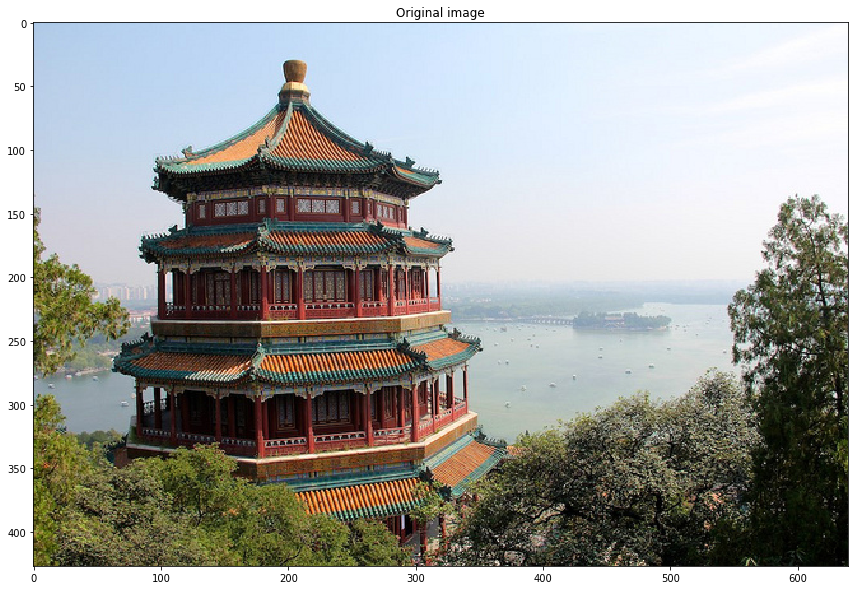

In [4]:
plt.figure(figsize=(15,10))
plt.imshow(dataset[0].astype(np.uint8))
plt.title('Original image');

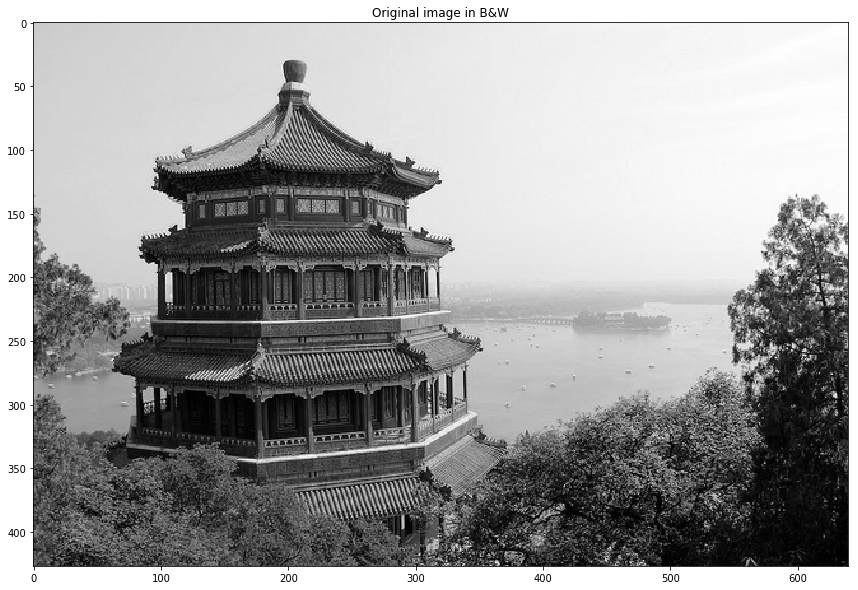

In [5]:
plt.figure(figsize=(15,10))
plt.imshow(np.dot(dataset[0],[1/3,1/3,1/3]), cmap="gray")
plt.title('Original image in B&W');

In [6]:
# Create 2 filters
filters = np.zeros((7, 7, c, 2))
filters[3,:,:,0] = 1 # Horizontal filter
filters[:,3,:,1] = 1 # Vertical filter

In [7]:
X = tf.placeholder(tf.float32, shape=(None, h, w, c))
convolution = tf.nn.conv2d(X, filters, strides=[1,1,1,1], padding='SAME')

In [8]:
with tf.Session() as sess:
    output = sess.run(convolution, feed_dict={X:dataset})

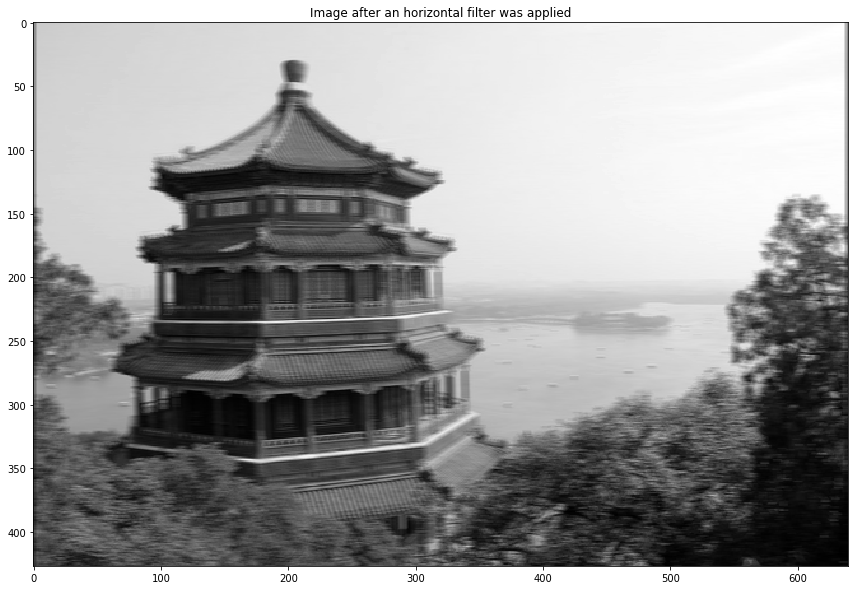

In [9]:
plt.figure(figsize=(15,10))
plt.imshow(output[0,:,:,0], cmap="gray")
plt.title('Image after an horizontal filter was applied');

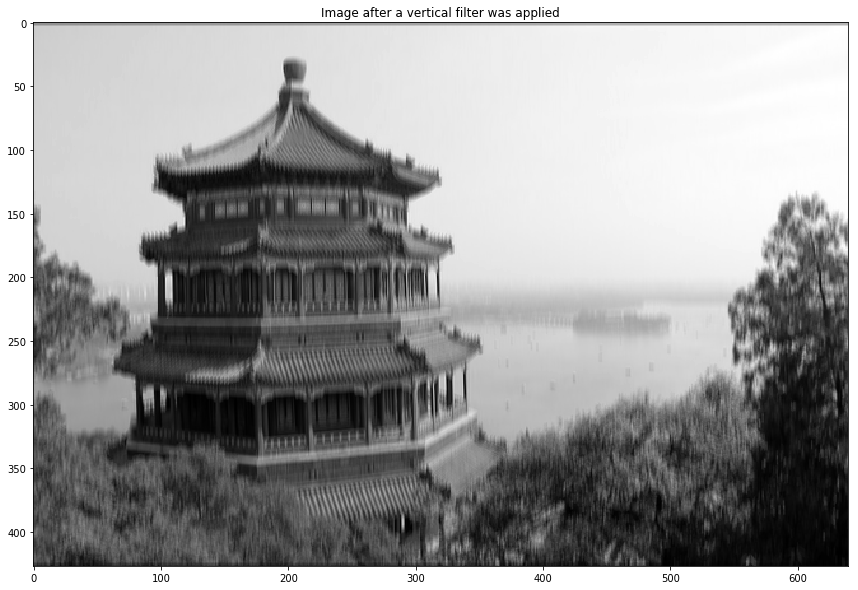

In [10]:
plt.figure(figsize=(15,10))
plt.imshow(output[0,:,:,1], cmap="gray")
plt.title('Image after a vertical filter was applied');

We can see that the horizontal/vertical filter "enhance" the horizontal/vertical features of the image, making them more prominent.

# MNIST

In [11]:
mnist = fetch_mldata('MNIST original')

X = mnist.data
y = mnist.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10000, random_state=42)
print('number of training sample :', len(X_train))
print('number of testing sample :', len(X_test))

number of training sample : 60000
number of testing sample : 10000


## Convnet (LeNet 5)

In [12]:
# Hyper parameters
n_x = 28**2
n_h, n_w, n_c = 28, 28, 1

n_f_conv1 = 5
n_s_conv1 = 1
n_c_conv1 = 6
pad_conv1 = 'SAME'

n_f_pool1 = 2
n_s_pool1 = 2

n_f_conv2 = 5
n_s_conv2 = 1
n_c_conv2 = 16
pad_conv2 = 'VALID'

n_f_pool2 = 2
n_s_pool2 = 2

n_fc1 = 400
n_fc2 = 200
n_fc3 = 10

learning_rate=0.001

def Make_Graph(learning_rate):

    tf.reset_default_graph()

    with tf.name_scope('inputs'):
        X = tf.placeholder(tf.float32, shape=(None, n_x), name='X')
        X_reshaped = tf.reshape(X, shape=(-1, n_h, n_w, n_c), name='X_reshaped')
        y = tf.placeholder(tf.int32, shape=(None), name='y')

    with tf.name_scope('parameters'):
        xavier_initializer = tf.contrib.layers.xavier_initializer()
        W_conv1 = tf.get_variable('W_conv1', shape=(n_f_conv1, n_f_conv1, n_c, n_c_conv1), initializer=xavier_initializer)
        W_conv2 = tf.get_variable('W_conv2', shape=(n_f_conv2, n_f_conv2, n_c_conv1, n_c_conv2), initializer=xavier_initializer)
    
    with tf.name_scope('ConvNet'):
        conv1 = tf.nn.conv2d(X_reshaped, W_conv1, strides=[1, n_s_conv1, n_s_conv1, 1], padding=pad_conv1, name='Conv1')
        A1 = tf.nn.tanh(conv1)

        max_pool1 = tf.nn.max_pool(A1, ksize=[1, n_f_pool1, n_f_pool1, 1], strides=[1, n_s_pool1, n_s_pool1, 1], padding='VALID')

        conv2 = tf.nn.conv2d(max_pool1, W_conv2, strides=[1, n_s_conv2, n_s_conv2, 1], padding=pad_conv2, name='Conv2')
        A2 = tf.nn.tanh(conv2)

        max_pool2 = tf.nn.max_pool(A2, ksize=[1, n_f_pool2, n_f_pool2, 1], strides=[1, n_s_pool2, n_s_pool2, 1], padding='VALID')

        max_pool2_flattened = tf.contrib.layers.flatten(max_pool2)

        fc1 = tf.layers.dense(max_pool2_flattened, n_fc1, activation=tf.nn.tanh, kernel_initializer=xavier_initializer, name='FC1')

        fc2 = tf.layers.dense(fc1, n_fc2, activation=tf.nn.tanh, kernel_initializer=xavier_initializer, name='FC2')

        logits = tf.layers.dense(fc2, n_fc3, kernel_initializer=xavier_initializer, name='FC3')

    with tf.name_scope('cost'):
        loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
        cost = tf.reduce_mean(loss, name='cost')
    
    with tf.name_scope('optimizer'):
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    with tf.name_scope('evaluation'):
        correct = tf.nn.in_top_k(logits, y, 1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

    return X, y, cost, optimizer, accuracy

In [13]:
def get_model_params():
    gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
    return {gvar.op.name: value for gvar, value in zip(gvars, tf.get_default_session().run(gvars))}

def restore_model_params(model_params):
    gvar_names = list(model_params.keys())
    assign_ops = {gvar_name: tf.get_default_graph().get_operation_by_name(gvar_name + "/Assign")
                  for gvar_name in gvar_names}
    init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
    feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
    tf.get_default_session().run(assign_ops, feed_dict=feed_dict)

In [14]:
def model(X_train, y_train, X_test, y_test, n_epochs=50, batch_size=256, learning_rate=0.001, max_checks_without_progress=10):
    
    X, y, cost, optimizer, accuracy = Make_Graph(learning_rate)
    
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    
    train_cost_list = []
    test_cost_list = []
    best_cost = np.inf
    best_model_params = None
    
    with tf.Session() as sess:
        sess.run(init)
        
        for epoch in range(n_epochs):
            mini_batches = make_minibatches(X_train, y_train, batch_size)
            
            train_cost = 0
            for X_batch, y_batch in mini_batches:
                batch_cost, _ = sess.run([cost, optimizer], feed_dict={X:X_batch, y:y_batch})
                train_cost += batch_cost
                
            n_batch = len(mini_batches)
            train_cost /= n_batch
            train_cost_list.append(train_cost)
            
            test_cost, test_acc = sess.run([cost, accuracy], ({X:X_test, y:y_test}))
            test_cost_list.append(test_cost)
            
            if epoch%5==0:
                print('Epoch %i \t Test accuracy : %.2f %%' %(epoch, (100*test_acc)))
                
            if test_cost < best_cost:
                best_model_params = get_model_params()
                best_cost = test_cost
                best_acc = test_acc
                best_epoch = epoch
                checks_without_progress = 0
            else:
                checks_without_progress += 1
                if checks_without_progress > max_checks_without_progress:
                    print("\nEarly stopping!\nModel restored after epoch ", best_epoch)
                    break
            
        if best_model_params:
            restore_model_params(best_model_params)
        
        mini_batches = make_minibatches(X_train, y_train, batch_size)
        final_train_cost, final_train_acc = 0, 0
        for X_batch, y_batch in mini_batches:
            batch_train_cost, batch_train_acc = sess.run([cost, accuracy], feed_dict={X: X_batch,y: y_batch})
            final_train_cost += batch_train_cost
            final_train_acc += batch_train_acc
        final_train_cost /= len(mini_batches)
        final_train_acc /= len(mini_batches)
        
        print("\nFinal metrics")
        print("Train acc : %.2f %% \t Test acc : %.2f %%" %(final_train_acc*100, best_acc*100))
        print("Train cost : %.5f \t Test cost : %.5f" %(final_train_cost, best_cost))
        
        plt.plot(train_cost_list, 'b-', label='Train cost')
        plt.plot(test_cost_list, 'r--', label='Test cost')
        plt.xlabel('# iter')
        plt.title('Evolution of cost function during training')
        plt.legend()

        saver.save(sess, "./Model_trained/MNIST_LeNet5")

Epoch 0 	 Test accuracy : 96.31 %
Epoch 5 	 Test accuracy : 98.25 %
Epoch 10 	 Test accuracy : 98.25 %
Epoch 15 	 Test accuracy : 98.53 %
Epoch 20 	 Test accuracy : 98.21 %
Epoch 25 	 Test accuracy : 98.60 %
Epoch 30 	 Test accuracy : 98.50 %

Early stopping!
Model restored after epoch  13

Final metrics
Train acc : 99.91 % 	 Test acc : 98.63 %
Train cost : 0.00407 	 Test cost : 0.05299


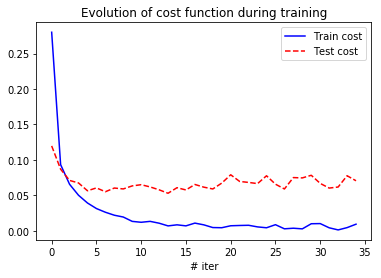

In [15]:
model(X_train, y_train, X_test, y_test, n_epochs=100, batch_size=256, learning_rate=0.001, max_checks_without_progress=20)

## Convnet (LeNet 5) + Dropout

In [16]:
# Hyper parameters
n_x = 28**2
n_h, n_w, n_c = 28, 28, 1

n_f_conv1 = 5
n_s_conv1 = 1
n_c_conv1 = 10
pad_conv1 = 'SAME'

n_f_pool1 = 2
n_s_pool1 = 2

n_f_conv2 = 5
n_s_conv2 = 1
n_c_conv2 = 20
pad_conv2 = 'VALID'

n_f_pool2 = 2
n_s_pool2 = 2

n_fc1 = 400
n_fc2 = 200
n_fc3 = 10

learning_rate=0.001

def Make_Graph2(learning_rate):

    tf.reset_default_graph()

    with tf.name_scope('inputs'):
        X = tf.placeholder(tf.float32, shape=(None, n_x), name='X')
        X_reshaped = tf.reshape(X, shape=(-1, n_h, n_w, n_c), name='X_reshaped')
        y = tf.placeholder(tf.int32, shape=(None), name='y')
        training = tf.placeholder(tf.bool, name='training')

    with tf.name_scope('parameters'):
        xavier_initializer = tf.contrib.layers.xavier_initializer()
        W_conv1 = tf.get_variable('W_conv1', shape=(n_f_conv1, n_f_conv1, n_c, n_c_conv1), initializer=xavier_initializer)
        W_conv2 = tf.get_variable('W_conv2', shape=(n_f_conv2, n_f_conv2, n_c_conv1, n_c_conv2), initializer=xavier_initializer)
    
    with tf.name_scope('ConvNet'):
        conv1 = tf.nn.conv2d(X_reshaped, W_conv1, strides=[1, n_s_conv1, n_s_conv1, 1], padding=pad_conv1, name='Conv1')
        A1 = tf.nn.relu(conv1)

        max_pool1 = tf.nn.max_pool(A1, ksize=[1, n_f_pool1, n_f_pool1, 1], strides=[1, n_s_pool1, n_s_pool1, 1], padding='VALID')

        conv2 = tf.nn.conv2d(max_pool1, W_conv2, strides=[1, n_s_conv2, n_s_conv2, 1], padding=pad_conv2, name='Conv2')
        A2 = tf.nn.relu(conv2)

        max_pool2 = tf.nn.max_pool(A2, ksize=[1, n_f_pool2, n_f_pool2, 1], strides=[1, n_s_pool2, n_s_pool2, 1], padding='VALID')

        max_pool2_flattened = tf.contrib.layers.flatten(max_pool2)
        
        fc1 = tf.layers.dense(max_pool2_flattened, n_fc1, activation=tf.nn.relu, kernel_initializer=xavier_initializer, name='FC1')
        fc1_dropout = tf.layers.dropout(fc1, 0.5, training=training)
        
        fc2 = tf.layers.dense(fc1_dropout, n_fc2, activation=tf.nn.relu, kernel_initializer=xavier_initializer, name='FC2')
        fc2_dropout = tf.layers.dropout(fc2, 0.5, training=training)

        logits = tf.layers.dense(fc2_dropout, n_fc3, kernel_initializer=xavier_initializer, name='FC3')

    with tf.name_scope('cost'):
        loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
        cost = tf.reduce_mean(loss, name='cost')
    
    with tf.name_scope('optimizer'):
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    with tf.name_scope('evaluation'):
        correct = tf.nn.in_top_k(logits, y, 1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

    return X, y, training, cost, optimizer, accuracy

In [17]:
def model2(X_train, y_train, X_test, y_test, n_epochs=50, batch_size=256, learning_rate=0.001, max_checks_without_progress=10):
    
    X, y, training, cost, optimizer, accuracy = Make_Graph2(learning_rate)
    
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    
    train_cost_list = []
    test_cost_list = []
    best_cost = np.inf
    best_model_params = None
    
    with tf.Session() as sess:
        sess.run(init)
        
        for epoch in range(n_epochs):
            mini_batches = make_minibatches(X_train, y_train, batch_size)
            
            train_cost = 0
            for X_batch, y_batch in mini_batches:
                batch_cost, _ = sess.run([cost, optimizer], feed_dict={X:X_batch, y:y_batch, training:True})
                train_cost += batch_cost
                
            n_batch = len(mini_batches)
            train_cost /= n_batch
            train_cost_list.append(train_cost)
            
            test_cost, test_acc = sess.run([cost, accuracy], ({X:X_test, y:y_test, training:False}))
            test_cost_list.append(test_cost)
            
            if epoch%5==0:
                print('Epoch %i \t Test accuracy : %.2f %%' %(epoch, (100*test_acc)))
                
            if test_cost < best_cost:
                best_model_params = get_model_params()
                best_cost = test_cost
                best_acc = test_acc
                best_epoch = epoch
                checks_without_progress = 0
            else:
                checks_without_progress += 1
                if checks_without_progress > max_checks_without_progress:
                    print("\nEarly stopping!\nModel restored after epoch ", best_epoch)
                    break
            
        if best_model_params:
            restore_model_params(best_model_params)
        
        mini_batches = make_minibatches(X_train, y_train, batch_size)
        final_train_cost, final_train_acc = 0, 0
        for X_batch, y_batch in mini_batches:
            batch_train_cost, batch_train_acc = sess.run([cost, accuracy], feed_dict={X: X_batch,y: y_batch, training:False})
            final_train_cost += batch_train_cost
            final_train_acc += batch_train_acc
        final_train_cost /= len(mini_batches)
        final_train_acc /= len(mini_batches)
        
        print("\nFinal metrics")
        print("Train acc : %.2f %% \t Test acc : %.2f %%" %(final_train_acc*100, best_acc*100))
        print("Train cost : %.5f \t Test cost : %.5f" %(final_train_cost, best_cost))
        
        plt.plot(train_cost_list, 'b-', label='Train cost')
        plt.plot(test_cost_list, 'r--', label='Test cost')
        plt.xlabel('# iter')
        plt.title('Evolution of cost function during training')
        plt.legend()

        saver.save(sess, "./Model_trained/MNIST_ConvNet2")

Epoch 0 	 Test accuracy : 95.50 %
Epoch 5 	 Test accuracy : 98.60 %
Epoch 10 	 Test accuracy : 98.66 %
Epoch 15 	 Test accuracy : 99.02 %
Epoch 20 	 Test accuracy : 99.02 %
Epoch 25 	 Test accuracy : 99.03 %
Epoch 30 	 Test accuracy : 98.82 %
Epoch 35 	 Test accuracy : 99.06 %

Early stopping!
Model restored after epoch  15

Final metrics
Train acc : 99.68 % 	 Test acc : 99.02 %
Train cost : 0.01228 	 Test cost : 0.03809


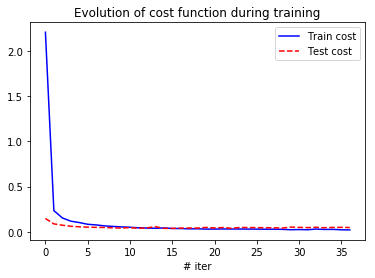

In [18]:
model2(X_train, y_train, X_test, y_test, n_epochs=100, batch_size=256, learning_rate=0.001, max_checks_without_progress=20)

## Deeper ConvNet

In [19]:
# Hyper parameters
n_x = 28**2
n_h, n_w, n_c = 28, 28, 1

n_f_conv1 = 5
n_s_conv1 = 1
n_c_conv1 = 10
pad_conv1 = 'SAME'

n_f_pool1 = 2
n_s_pool1 = 2

n_f_conv2 = 5
n_s_conv2 = 1
n_c_conv2 = 20
pad_conv2 = 'SAME'

n_f_pool2 = 2
n_s_pool2 = 2

n_f_conv3 = 3
n_s_conv3 = 1
n_c_conv3 = 40
pad_conv3 = 'VALID'


n_fc1 = 500
n_fc2 = 200
n_fc3 = 10

learning_rate=0.001

def Make_Graph3(learning_rate):

    tf.reset_default_graph()

    with tf.name_scope('inputs'):
        X = tf.placeholder(tf.float32, shape=(None, n_x), name='X')
        X_reshaped = tf.reshape(X, shape=(-1, n_h, n_w, n_c), name='X_reshaped')
        y = tf.placeholder(tf.int32, shape=(None), name='y')
        training = tf.placeholder(tf.bool, name='training')

    with tf.name_scope('parameters'):
        xavier_initializer = tf.contrib.layers.xavier_initializer()
        W_conv1 = tf.get_variable('W_conv1', shape=(n_f_conv1, n_f_conv1, n_c, n_c_conv1), initializer=xavier_initializer)
        W_conv2 = tf.get_variable('W_conv2', shape=(n_f_conv2, n_f_conv2, n_c_conv1, n_c_conv2), initializer=xavier_initializer)
        W_conv3 = tf.get_variable('W_conv3', shape=(n_f_conv3, n_f_conv3, n_c_conv2, n_c_conv3), initializer=xavier_initializer)
    
    with tf.name_scope('ConvNet'):
        conv1 = tf.nn.conv2d(X_reshaped, W_conv1, strides=[1, n_s_conv1, n_s_conv1, 1], padding=pad_conv1, name='Conv1')
        A1 = tf.nn.relu(conv1)
        max_pool1 = tf.nn.max_pool(A1, ksize=[1, n_f_pool1, n_f_pool1, 1], strides=[1, n_s_pool1, n_s_pool1, 1], padding='VALID')

        conv2 = tf.nn.conv2d(max_pool1, W_conv2, strides=[1, n_s_conv2, n_s_conv2, 1], padding=pad_conv2, name='Conv2')
        A2 = tf.nn.relu(conv2)
        max_pool2 = tf.nn.max_pool(A2, ksize=[1, n_f_pool2, n_f_pool2, 1], strides=[1, n_s_pool2, n_s_pool2, 1], padding='VALID')
        
        conv3 = tf.nn.conv2d(max_pool2, W_conv3, strides=[1, n_s_conv3, n_s_conv3, 1], padding=pad_conv3, name='Conv3')
        A3 = tf.nn.relu(conv3)
        A3_flattened = tf.contrib.layers.flatten(A3)
        
        fc1 = tf.layers.dense(A3_flattened, n_fc1, activation=tf.nn.relu, kernel_initializer=xavier_initializer, name='FC1')
        fc1_dropout = tf.layers.dropout(fc1, 0.5, training=training)
        
        fc2 = tf.layers.dense(fc1_dropout, n_fc2, activation=tf.nn.relu, kernel_initializer=xavier_initializer, name='FC2')
        fc2_dropout = tf.layers.dropout(fc2, 0.5, training=training)

        logits = tf.layers.dense(fc2_dropout, n_fc3, kernel_initializer=xavier_initializer, name='FC3')

    with tf.name_scope('cost'):
        loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
        cost = tf.reduce_mean(loss, name='cost')
    
    with tf.name_scope('optimizer'):
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    with tf.name_scope('evaluation'):
        correct = tf.nn.in_top_k(logits, y, 1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

    return X, y, training, cost, optimizer, accuracy

In [20]:
def model3(X_train, y_train, X_test, y_test, n_epochs=50, batch_size=256, learning_rate=0.001, max_checks_without_progress=10):
    
    X, y, training, cost, optimizer, accuracy = Make_Graph3(learning_rate)
    
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    
    train_cost_list = []
    test_cost_list = []
    best_cost = np.inf
    best_model_params = None
    
    with tf.Session() as sess:
        sess.run(init)
        
        for epoch in range(n_epochs):
            mini_batches = make_minibatches(X_train, y_train, batch_size)
            
            train_cost = 0
            for X_batch, y_batch in mini_batches:
                batch_cost, _ = sess.run([cost, optimizer], feed_dict={X:X_batch, y:y_batch, training:True})
                train_cost += batch_cost
                
            n_batch = len(mini_batches)
            train_cost /= n_batch
            train_cost_list.append(train_cost)
            
            test_cost, test_acc = sess.run([cost, accuracy], ({X:X_test, y:y_test, training:False}))
            test_cost_list.append(test_cost)
            
            if epoch%5==0:
                print('Epoch %i \t Test accuracy : %.2f %%' %(epoch, (100*test_acc)))
                
            if test_cost < best_cost:
                best_model_params = get_model_params()
                best_cost = test_cost
                best_acc = test_acc
                best_epoch = epoch
                checks_without_progress = 0
            else:
                checks_without_progress += 1
                if checks_without_progress > max_checks_without_progress:
                    print("\nEarly stopping!\nModel restored after epoch ", best_epoch)
                    break
            
        if best_model_params:
            restore_model_params(best_model_params)
        
        mini_batches = make_minibatches(X_train, y_train, batch_size)
        final_train_cost, final_train_acc = 0, 0
        for X_batch, y_batch in mini_batches:
            batch_train_cost, batch_train_acc = sess.run([cost, accuracy], feed_dict={X: X_batch,y: y_batch, training:False})
            final_train_cost += batch_train_cost
            final_train_acc += batch_train_acc
        final_train_cost /= len(mini_batches)
        final_train_acc /= len(mini_batches)
        
        print("\nFinal metrics")
        print("Train acc : %.2f %% \t Test acc : %.2f %%" %(final_train_acc*100, best_acc*100))
        print("Train cost : %.5f \t Test cost : %.5f" %(final_train_cost, best_cost))
        
        plt.plot(train_cost_list, 'b-', label='Train cost')
        plt.plot(test_cost_list, 'r--', label='Test cost')
        plt.xlabel('# iter')
        plt.title('Evolution of cost function during training')
        plt.legend()

        saver.save(sess, "./Model_trained/MNIST_ConvNet3")

Epoch 0 	 Test accuracy : 96.86 %
Epoch 5 	 Test accuracy : 98.80 %
Epoch 10 	 Test accuracy : 98.59 %
Epoch 15 	 Test accuracy : 98.86 %
Epoch 20 	 Test accuracy : 98.77 %
Epoch 25 	 Test accuracy : 98.96 %

Early stopping!
Model restored after epoch  7

Final metrics
Train acc : 99.56 % 	 Test acc : 98.93 %
Train cost : 0.01381 	 Test cost : 0.04039


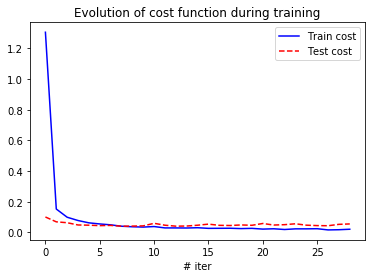

In [21]:
model3(X_train, y_train, X_test, y_test, n_epochs=100, batch_size=256, learning_rate=0.001, max_checks_without_progress=20)

## Conclusion

- The reproduction of the LeNet-5 model, using tanh as activation function and no regularization, is able to reach ~98.5 % accuracy on MNIST. 
- Adding dropout regularization and replacing the activation function by ReLU is pushing the accuracy to ~99 %. 
- Adding one more layer of convolution doesn't seem to improve the performance.